In [2]:
# Clear Jupyter notebook output and clear all variables
from IPython.display import clear_output
clear_output(wait=True)

# Remove all user-defined variables
for name in dir():
    if not name.startswith('_'):
        del globals()[name]
# Set path to the parent directory
import sys
import os
file = "/home/ashwin/GIT/PulsarAnalyticsKit/"
sys.path.append(file)

# Import necessary modules
from core.pulsar_analysis import pulsar_analysis
from core.generic_plotting import *


In [3]:
class pulsar_analysis(pulsar_analysis):
    def template(self):
        print("Template for pulsar analysis")

In [4]:
vela_long_data = "../Data4Analysis/ch00_B0833-45_20150612_191438_010_4.txt"
pulsar = pulsar_analysis(vela_long_data, channel_names=["N", "S"], data_type='ascii',block_size=512, avg_blocks=60, sample_rate=33e6)

Given Data is of ndim : 2 . shape : 2
file_path: ../Data4Analysis/ch00_B0833-45_20150612_191438_010_4.txt
data_type: ascii
n_channels: 2
raw_data shape :  (30719999, 2)
channel_names: ['N', 'S']
block_size: 512
avg_blocks: 60
sample_rate: 33000000.0
intensity_matrix_ch_s shape :  (2,)
dedispersed_ch_s shape :  (2,)
dedispersed_choped_ch_s: [None None]
folded_ch_s: [None None]
center_freq_MHZ: 326.5
bandwidth_MHZ: 16.5
skip_rows: 1


/home/ashwin/GIT/PulsarAnalyticsKit/core/generic_plotting.py:341: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


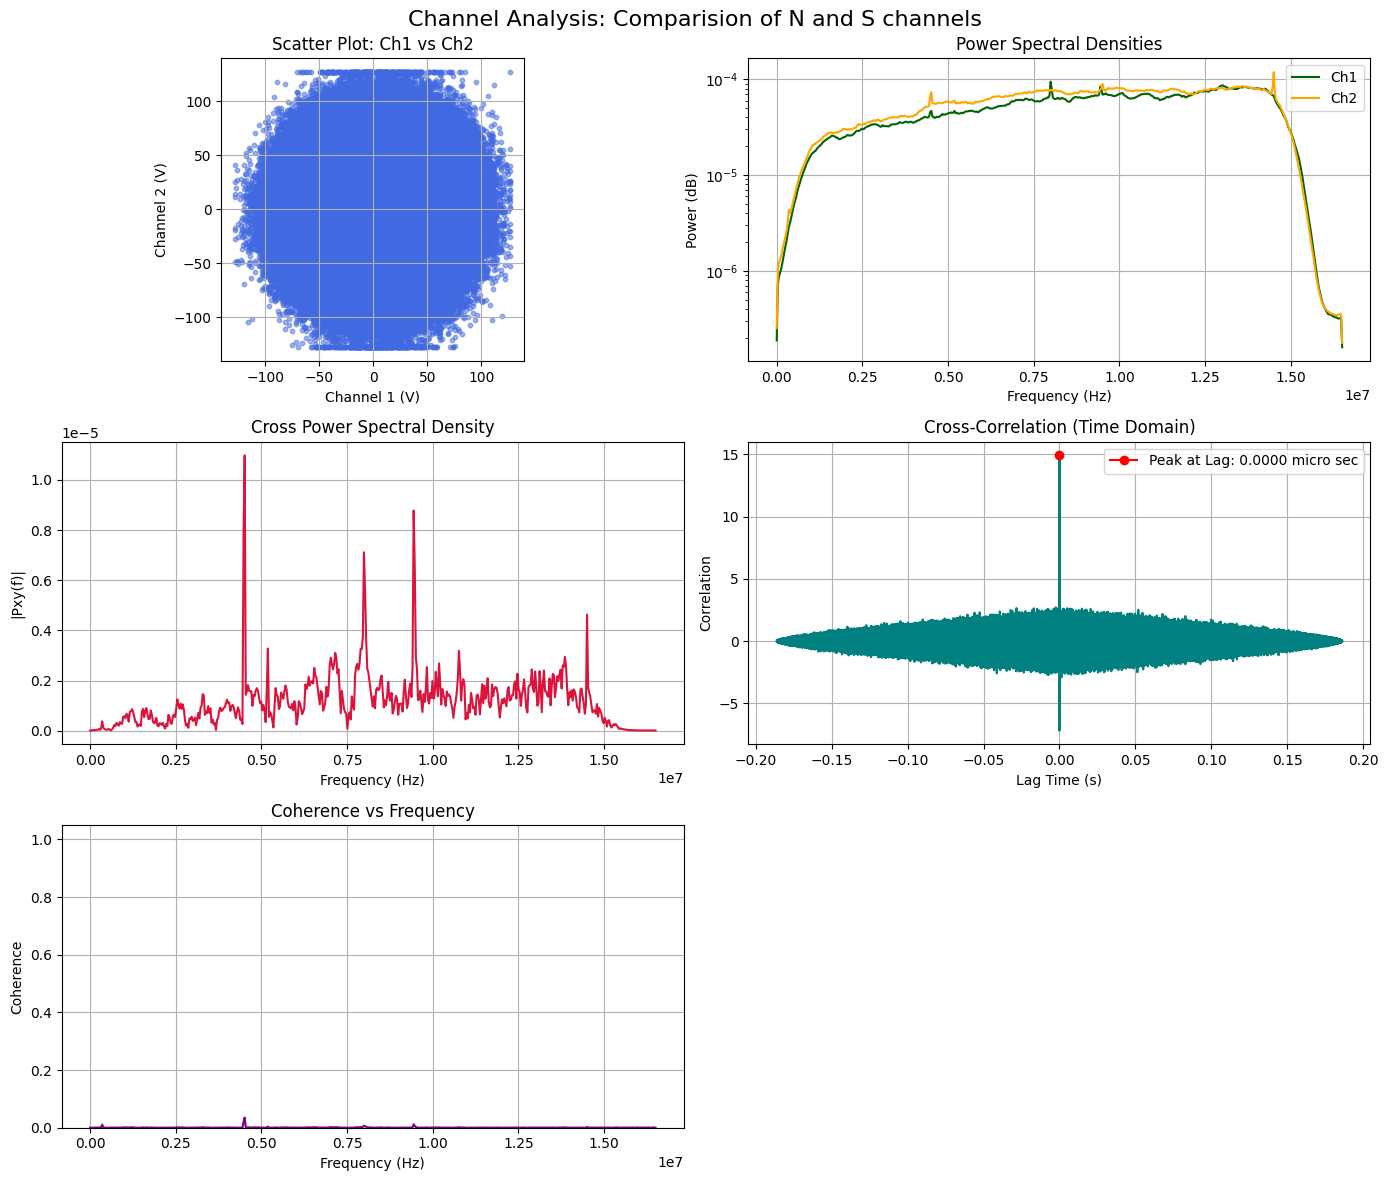

In [5]:
percentofData = 20 # Percentage of data to analyze
n = int(pulsar.raw_data.shape[0] * percentofData / 100)

ch0 = pulsar.raw_data[:n , 0]
ch1 = pulsar.raw_data[:n, 1]
fs = pulsar.sample_rate

compare_channels(ch0,ch1, fs, label="Comparision of N and S channels",)

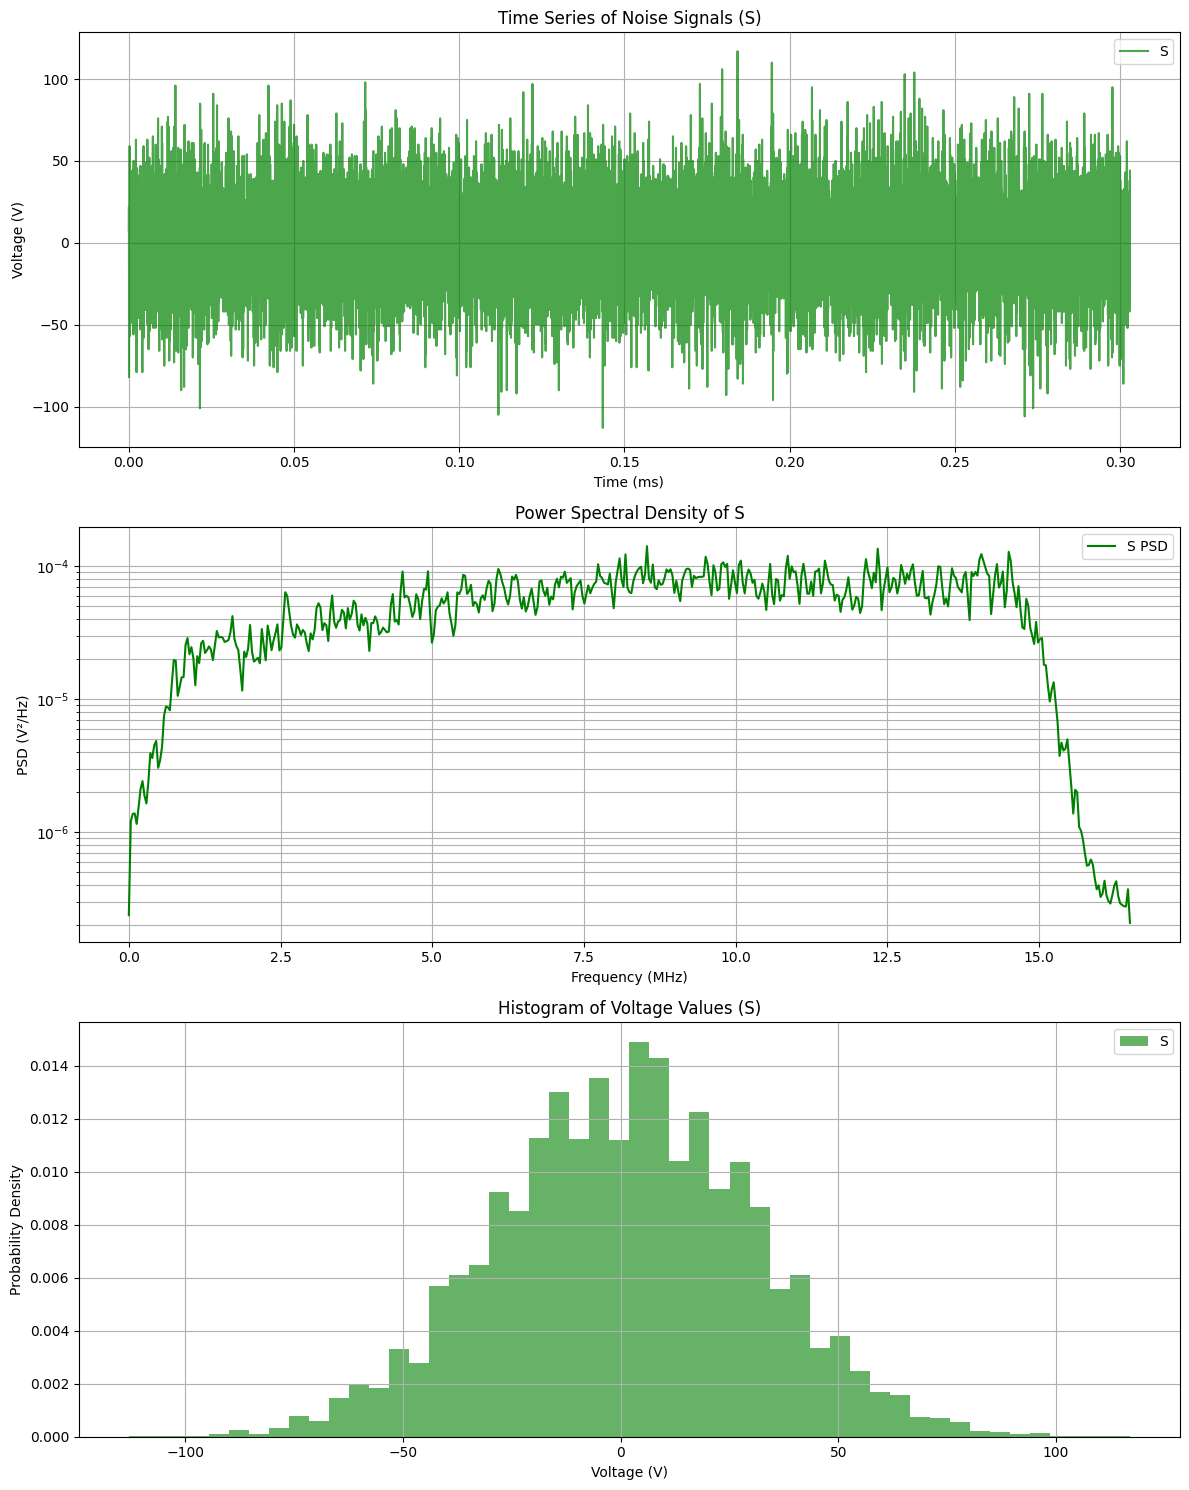

In [6]:
Plot_characterstics(pulsar,channel=1)

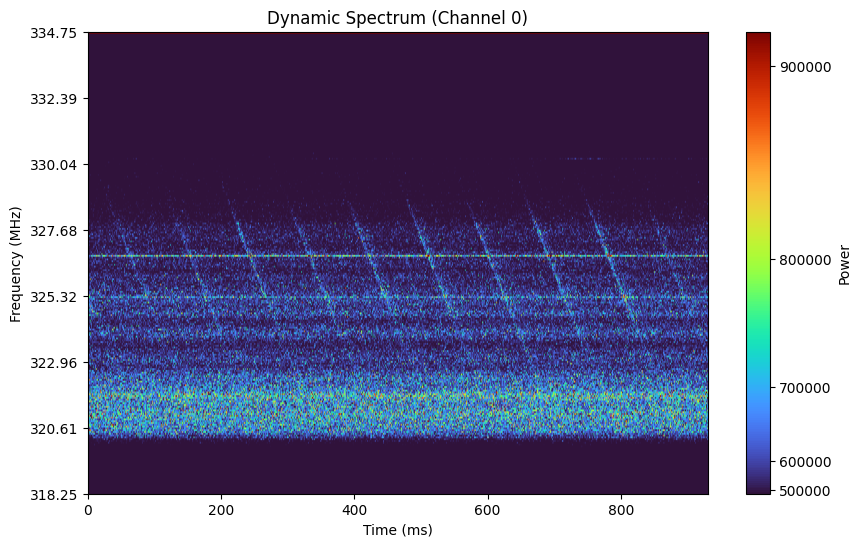

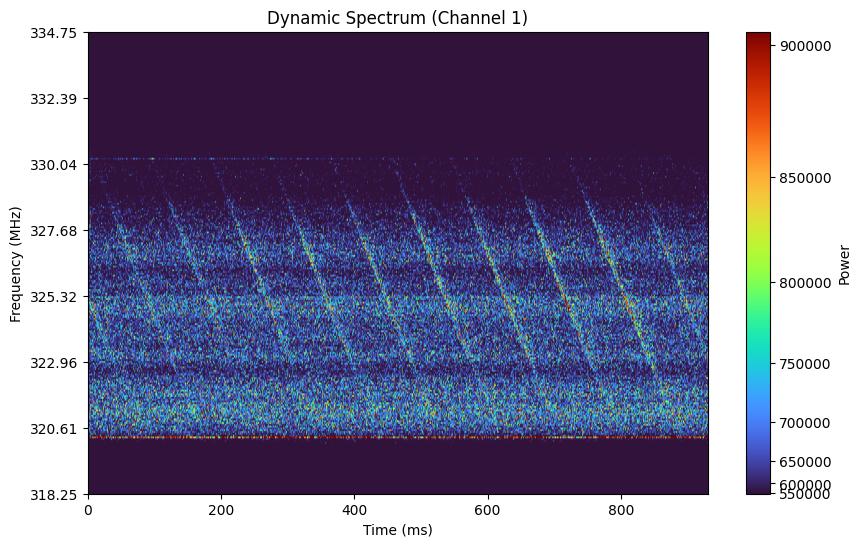

In [7]:
pulsar.compute_intensity_matrix()
plot_intensity_matrix(pulsar,channel = 0)
plot_intensity_matrix(pulsar,channel = 1)

In [13]:
import numpy as np

time_bin =  1/ pulsar.avg_blocks 

def channel_efficiency(matrix):
    """
    Compute efficiency for each frequency channel in the dynamic spectrum.

    Efficiency E = mean / (std * sqrt(TBP)) where TBP = number of time bins

    Args:
        matrix (2D numpy array): [time, frequency] intensity matrix

    Returns:
        1D numpy array of efficiencies for each frequency channel
    """
    n_time, n_freq = matrix.shape
    means = matrix.mean(axis=0)
    stds = matrix.std(axis=0)
    stds = np.where(stds == 0, 1, stds)  # Avoid division by zero

    TBP = 60
    efficiencies = means / (stds * np.sqrt(TBP))
    return efficiencies

def remove_rfi_by_efficiency(matrix, threshold=1 - 4 / np.sqrt(1024), fill_value=0, verbose=True):
    """
    Mask or replace RFI-affected frequency channels using efficiency threshold.

    Args:
        matrix (2D array): [time, frequency] intensity matrix
        threshold (float): Efficiency cutoff threshold (default = 1 - 4/√M where M=1024)
        fill_value: Value to replace RFI-affected channels with (e.g., np.nan or 0)
        verbose (bool): Whether to print removed channels info

    Returns:
        Cleaned 2D matrix
    """
    efficiency = channel_efficiency(matrix)
    bad_channels_up = efficiency < 1 - threshold
    bad_channels_down =efficiency > 1 + threshold
    bad_channels = np.logical_or(bad_channels_up, bad_channels_down)

    cleaned = matrix.copy()
    cleaned[:, bad_channels] = fill_value

    if verbose:
        print(f"Removed {np.sum(bad_channels)} RFI channels out of {matrix.shape[1]} using efficiency threshold {threshold:.4f}")
    return cleaned


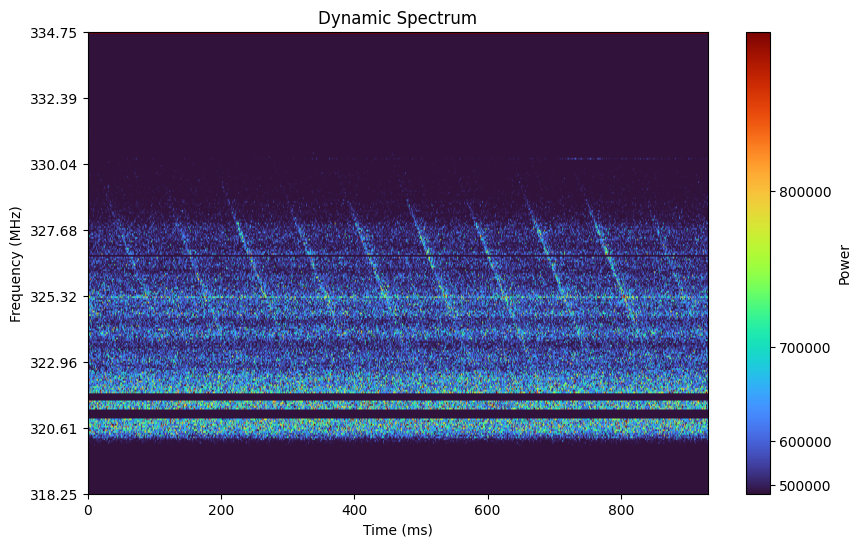

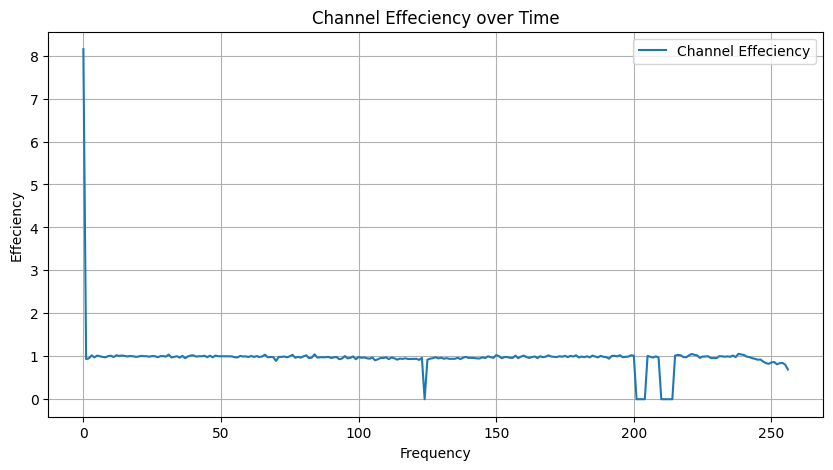

Removed 22 RFI channels out of 257 using efficiency threshold 0.1000


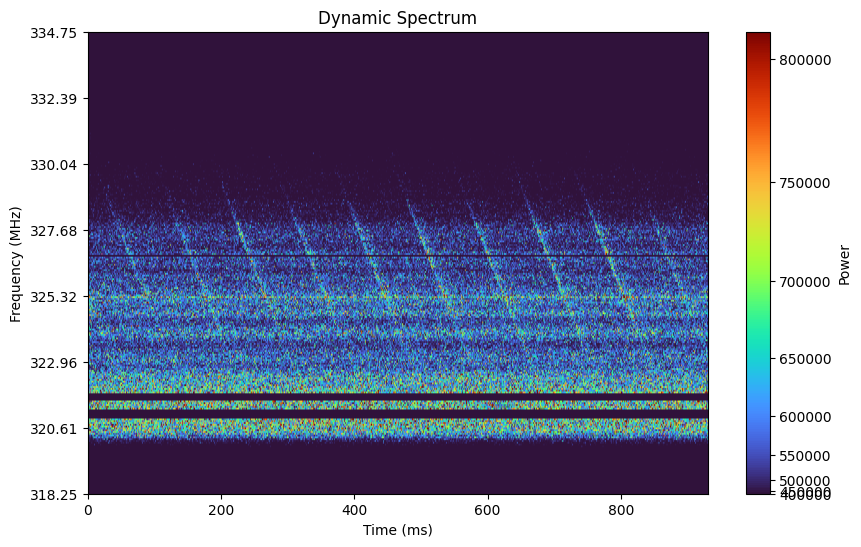

In [15]:
matrix = pulsar.intensity_matrix_ch_s[0]
plot_intensity_matrix_single(matrix, pulsar.block_size, pulsar.avg_blocks, pulsar.sample_rate, pulsar.bandwidth_MHZ, pulsar.center_freq_MHZ, gamma=2.5)

effeciency = channel_efficiency(matrix)

# Plot the effeciency
plt.figure(figsize=(10, 5))     
plt.plot(effeciency, label='Channel Effeciency')
plt.xlabel('Frequency')
plt.ylabel('Effeciency')
plt.title('Channel Effeciency over Time')
plt.legend()
plt.grid()
plt.show()

plot_intensity_matrix_single(remove_rfi_by_efficiency(matrix,threshold = 0.1), pulsar.block_size, pulsar.avg_blocks, pulsar.sample_rate, pulsar.bandwidth_MHZ, pulsar.center_freq_MHZ, gamma=2.5)



Flagging 10 channels as RFI heavy
Flagging 1 channels as RFI heavy


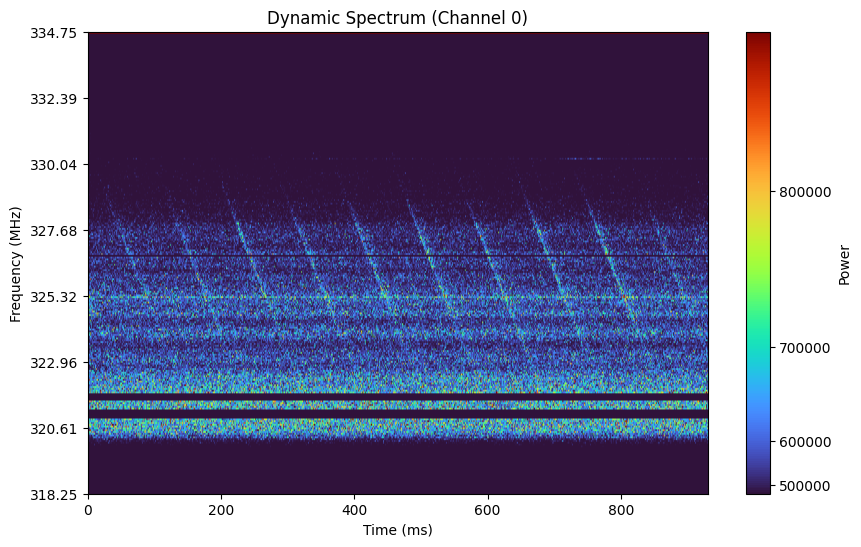

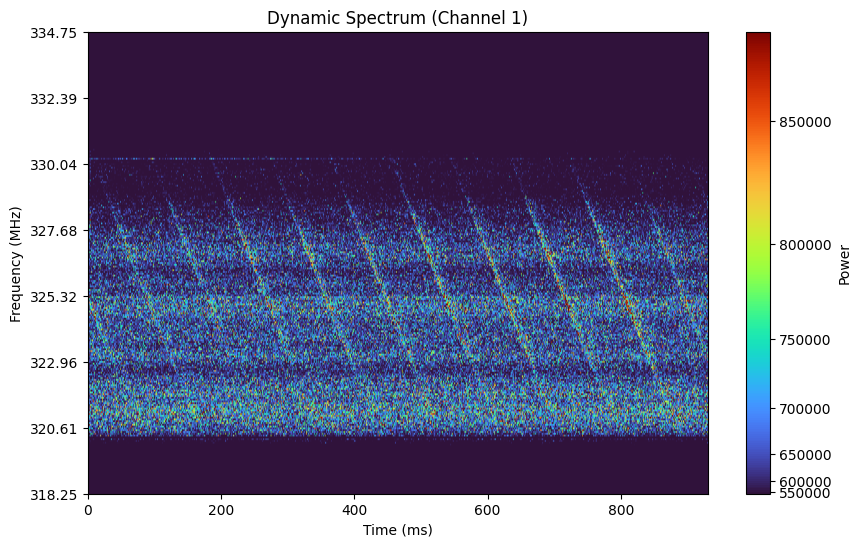

In [10]:
pulsar.compute_intensity_matrix()
pulsar.RFI_mitigation(freq_ch_std_threshold=1,freq_ch_mean_threshold=1,time_ch_threshold=7,fill_value=0)
plot_intensity_matrix(pulsar,channel = 0)
plot_intensity_matrix(pulsar,channel = 1)

In [11]:
from core.functions import *